<a href="https://colab.research.google.com/github/Warlord-K/TryOn/blob/master/Edit_Clothes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install transformers diffusers accelerate

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving green_hoodie.jpg to green_hoodie.jpg


In [ ]:
image_name = "Vishnu1.jpeg"
example_name = "green_hoodie.jpg"
res = (512,512)

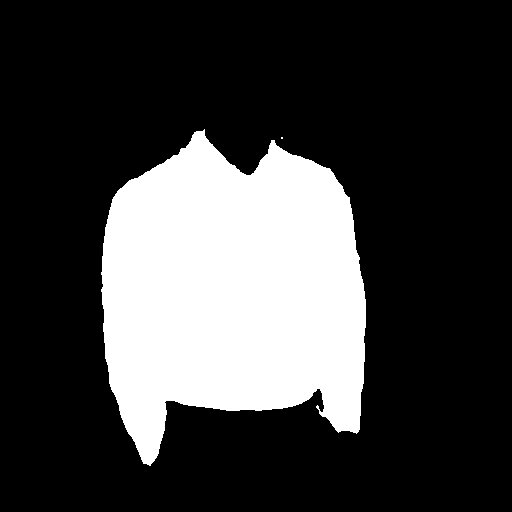

In [ ]:
from transformers import AutoFeatureExtractor, SegformerForSemanticSegmentation
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import requests
import torch.nn as nn
import torch
extractor = AutoFeatureExtractor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = SegformerForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

try:
  image = Image.open(image_name)
except Exception as e:
  url = "https://plus.unsplash.com/premium_photo-1673210886161-bfcc40f54d1f?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8cGVyc29uJTIwc3RhbmRpbmd8ZW58MHx8MHx8&w=1000&q=80"
  image = Image.open(requests.get(url, stream=True).raw)
  res = (512,768)
inputs = extractor(images=image, return_tensors="pt")

outputs = model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]
pred_seg[pred_seg != 4] = 0
pred_seg[pred_seg == 4] = 1
pred_seg = pred_seg.to(dtype = torch.float32)
# pred_seg = pred_seg.unsqueeze(dim = 0)
mask = to_pil_image(pred_seg)
mask.resize(res)

In [ ]:
from diffusers import StableDiffusionInpaintPipeline
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16
)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)

vae/diffusion_pytorch_model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [ ]:
from diffusers import DiffusionPipeline
pipe = DiffusionPipeline.from_pretrained(
    "Fantasy-Studio/Paint-by-Example",
    torch_dtype=torch.float16,
)
pipe = pipe.to("cuda")

unet/diffusion_pytorch_model.safetensors not found


Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

You are using a model of type clip_vision_model to instantiate a model of type clip. This is not supported for all configurations of models and can yield errors.


In [ ]:
example = Image.open(example_name)

In [ ]:
gen = pipe(image=image, mask_image = mask, example_image = example).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
prompt = "Man Wearing yellow t-shirt, high resolution"
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
gen = pipe(prompt=prompt, image=image, mask_image=mask).images[0]
gen.save("./man.png")

  0%|          | 0/50 [00:00<?, ?it/s]

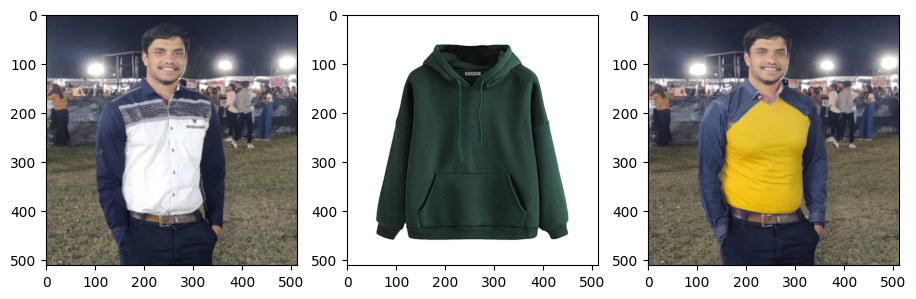

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

# display images

fig, ax = plt.subplots(1,3)
ax[0].imshow(image.resize(res))
ax[1].imshow(example.resize(res))
ax[2].imshow(gen.resize(res))